<a href="https://colab.research.google.com/github/ahsan-rahim/bai-fyp/blob/main/B_AI_FYP_Implementational_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Breast Cancer Detection Using Mask RCNN - Implementation Guide**

Welcome to the implementational guide for performing detection, localization and pixel level segmentation of breast cancer tumors on the InBreast Dataset.

Our model will be trained on the INbreast Dataset which is based on 125 total cases comprising of 415 images of mammograms from which approximately 95 cases are from women with both breasts affected (four images per case) and 25 cases are from mastectomy patients (two images per case). However since we are performing localization, we will only include images that contain atleast a single tumor and exclude all mammograms without any tumors.

The InBreast dataset contains mammogram images in the form of DICOM images with each corresponding image's pixel level annotations being contained within an XML file.

Before we can train our model, we'll have to perform some data preprocessing in order to setup our MASK-RCNN Model. Following is an overview of what we'll be doing in this implementational guide.

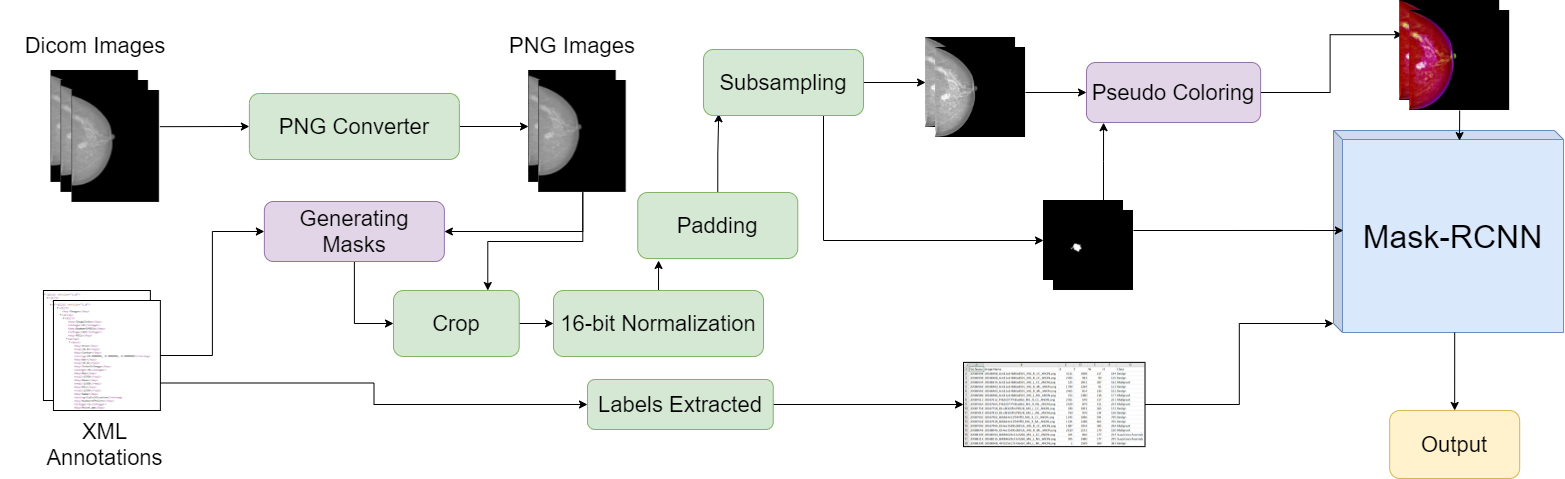

##**Mounting Google Drive:**

Since we are going to be using google colab to train our model, we can not store all our data and do our data preprocessing in google colabs temperory environment as it gets cleaned after a certain amount of time.

In order to make our data persist and we are going to use our google drive for as our persistant file system, as it will provide us with the storage space and directory structure we need to keep our project organized.

We are going to use the following lines of code to connect our google drive with this colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline


Mounted at /content/drive


Once our notebook is connected to our drive, we are going to upload the inbreast dataset under a folder called BCD.

Our resultant directory structure should look like this.

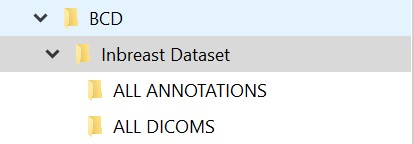

##**Converting DICOMS Images to PNG:**

The Inbreast dataset provides mammogram images in the standard Digital Imaging and Communications in Medicine (DICOM) format along with pixel level annotations in XML format. 

DICOM images are extremely hefty and are difficult to be trained upon, hence we will need to first convert the dicom images into png format in order to easily process and train our model upon those png images.

We will use the following code to convert the dicom images into png and save them under another directory with the inbreast dataset directory called ALL PNGS.

In [ ]:
import numpy as np 
import pydicom
import png
import os
import re


findfiles = os.listdir('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllDICOMs')
dcm = []

for file in findfiles:
  if file.endswith(".dcm"):
    dcm.append(os.path.join(file))

print(dcm)
print(len(dcm))


files = []
for name in dcm:
  files.append(re.findall( r"^([^.]*).*" , name)[0])
print(files)


for file in files:
    ds = pydicom.dcmread('AllDICOMs/%s.dcm'%file)
    shape = ds.pixel_array.shape
    
    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)

    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 256

    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)

    with open('AllPNG/%s.png'%file, 'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)


###**Sanity Check: Loading a test image:**
Lets try and load a test image to see if our files for converted properly.

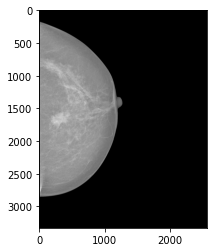

In [ ]:

# Load an color image in grayscale
#img = cv2.imread('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG/20587664_f4b2d377f43ba0bd_MG_R_ML_ANON.png')
img = cv2.imread('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG/22614236_1e5c3af078f74b05_MG_L_CC_ANON.png')

img.shape

#plt.imshow(img, cmap=plt.cm.bone)
#cv2.rectangle(img,(55,1962), (393,2249), (0, 100, 150), 30)

plt.imshow(img, cmap=plt.cm.bone)
plt.show()

## **Checking Unique Image Dimensions:**
Now we use the following script to see how many different dimensions/sizes of images do we have. 
This information will be helpful for us later.

In [ ]:

import os
file_sizes =[]
for filename in os.listdir('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG/'):
    if filename.endswith(".png"):
      img = cv2.imread('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG/'+filename)
      file_sizes.append(img.shape)

dim = set(file_sizes)
print(dim)


We have only two different image sizes (3328,2560) and (4084,3328)

##**Extracting Mass ROI's from XML files:**
Since we now have our images ready, we need to figure out a way to extract the mass region of interests (ROI's), since Mask RCNN does not require us to provide the bounding box cordinates of the ROI while training, we will only need to write a function that extracts the pixel level annotation provided with the Inbreast dataset in XML format and returns a binary mask for each mass ROI present in a particular mammogram.


We will use the following function to extract the ROI pixel values and generate a binary mask for each of the present masses.

We use will use the plistlib to access and traverse through the XML annotation files and use numpy to generate a binary mask.

##**Extracting Binary Masks from XML files for only Mass's:**

In [ ]:
from skimage.draw import polygon
import numpy as np
import plistlib

def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            
            if(roi['Name']=='Mass'):
              numPoints = roi['NumberOfPoints']
              points = roi['Point_px']
              assert numPoints == len(points)
              points = [load_point(point) for point in points]
              if len(points) <= 2:
                  for point in points:
                      mask[int(point[0]), int(point[1])] = 1
              else:
                  x, y = zip(*points)
                  x, y = np.array(x), np.array(y)
                  poly_x, poly_y = polygon(x, y, shape=imshape)
                  mask[poly_x, poly_y] = 1
    return mask


mask = load_inbreast_mask('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllXML/22614236.xml' , img.shape[0:2])

###**Sanity Check: Lets try displaying a contour mask overlay on actual image**
It works!

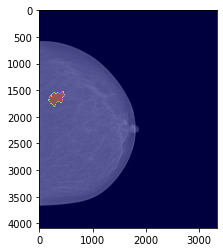

(4084, 3328)

In [ ]:
plt.imshow(img, cmap='gray')
plt.imshow(mask*255, cmap='jet', alpha=0.5)
plt.show()
img.shape
mask.shape

##**Converting contour masks to cordinates for bounding boxes:**
Even though we do not need to pass on a bounding box to Mask RCNN, we can easily generate the bounding box cordinates using opencv2 with the following code, incase we run some test experiments on some other models.


In [ ]:
import numpy as np

mask_img = masks1.astype(np.uint8)
#ret,thresh = cv2.threshold(mask_img,0,255,0)
contours,hierarchy = cv2.findContours(mask_img,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
cnt = contours[0]

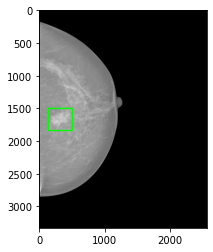

In [ ]:
for cnt in contours:
  
  x,y,w,h = cv2.boundingRect(cnt)
  img1 = cv2.rectangle(img,(x-20,y-20),(x+w+20,y+h+20),(0,255,0),20)

plt.imshow(img1)


##**Data Preprocessing Pipeline:**

The steps performed in the this section of the notebook are not mandatory. However, they are essential in producing satisfactory results.

The following piece of code is used to extract breast profiles from each mammogram image in the AllPNG folder. The profiles are used to extract image masks in a png format.

The excess black region is cropped out and the mammogram images are normalized to 16-bits. The images are then padded in a way to shift the scans of all breasts to the left side of the image while simultaneously resulting in square images.

This is a computationally heavy task, due to which the mammograms have been subsampled to 25% of their original size. The aspect ratio is maintained and the mammogram masks are scaled appropriately.

##**Preprocessing Mammograms:**

Note: This pipeline requires the load_inbreast() mask function to be defined, which we have defined earlier.

In [ ]:
import numpy as np
import cv2
from skimage.measure import label, regionprops


class Preprocess:
  def __init__(self, rawim, im, breast_mask, lesion_mask):
    self.raw = rawim
    self.image = im
    self.mask = breast_mask
    self.lesion_mask = lesion_mask

  def extract_breast_profile(image,lesion_mask, if_crop):    
    breast_mask = np.zeros(np.shape(image))
    breast_mask[image>0]=1
    
    labelim = label(breast_mask)
    props =  regionprops(labelim)
    
    #find the largest object as the breast
    area = 0
    ind = 1
    for i in range(0,len(props)):
      if area<props[i].filled_area:
          area = props[i].filled_area
          ind = i+1
    breast_mask = np.zeros(np.shape(image))
    breast_mask[labelim==ind]=1  
    labelim = label(breast_mask)       
    props =  regionprops(labelim)
    boundingbox = props[0].bbox
    
    #crop the breast mask and mammogram
    if if_crop == 1:
        breast_mask = breast_mask[boundingbox[0]:boundingbox[2],boundingbox[1]:boundingbox[3]]
        breast_raw_image = image[boundingbox[0]:boundingbox[2],boundingbox[1]:boundingbox[3]]
        lesion_mask = lesion_mask[boundingbox[0]:boundingbox[2],boundingbox[1]:boundingbox[3]]
    else:
        breast_raw_image = image
    
    breast_image = rescale2uint16(breast_raw_image,breast_mask)
    return Preprocess(breast_raw_image,breast_image,breast_mask,lesion_mask)


  def rescale2uint16(image,breast_mask):
    intensity_in_mask = image[breast_mask>0]
    #use top 0.2 percentile to do the strech
    maxi = np.percentile(intensity_in_mask,99.8)#np.max(intensity_in_mask)
    mini = np.percentile(intensity_in_mask,0.2)#np.min(intensity_in_mask)
    #stretch the image into 0~255
    
    image = 65535*(image-mini)/(maxi-mini)
    image[breast_mask==0] = 0
    image[image<0] = 0
    image[image>65535] = 65535
    image = np.uint16(image)
          
    return image

The following cell will create two new folders in your working directory, 'preprocesses_images' and 'preprocessed_mask'. These folders contain the resized and preprocessed images and the resized preprocessed image masks will later be used for further preprocessing steps.

Kindly note that the output files in the 'preprocessed_mask' folder will have the same names as their counterparts in the 'preprocessed_images' folder, with an addition at the end of the name which denotes the mask ID for that particular mammogram.
For e.g. the file '205869081' in the 'preprocessed_mask' folder denotes that it is the mask for the mammogram '20586908' image in 'preprocessed_images' and the '1' denotes that it is the first mask of the image.

There is mostly just 1 mass per image in the dataset but a few samples contain more.

In [ ]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage import io
from skimage.measure import label
import timeit

start = timeit.default_timer()

import warnings
warnings.filterwarnings("ignore")


# To pad image into a square shape
def padimages(image,file_name, ratio):
    [length, width] = np.shape(image)
    if length/width>ratio:#1024/800
        print('This image needs padding.')
        add_wid = round(length*(1/ratio)-width)
        pad = np.zeros((length,add_wid))
        pad = pad.astype(image.dtype)
        if '_R_' in file_name:
        #                pad on the left
            pad_image = np.concatenate((pad,image),axis=1)
        else:
            pad_image = np.concatenate((image,pad),axis=1)
            
    return pad_image


#from skimage import data, color, io, img_as_float

image_path = "/AllPNG/"
annotation_path = '/AllXML/'

save_image_path = "/preprocessed_image/"   
if not os.path.exists(save_image_path):        
    os.mkdir(save_image_path)
 
    
save_mask_path = "/preprocessed_mask/"    
if not os.path.exists(save_mask_path):        
    os.mkdir(save_mask_path)


file_names = os.listdir(image_path)    
file_names = sorted(file_names)


for i in range(0,len(file_names)):
  print(file_names[i])
  mammo = io.imread(image_path+file_names[i],0)
  
  lesion_mask = load_inbreast_mask(annotation_path+file_names[i].replace('png','xml'), mammo.shape[0:2])
  
  if np.max(lesion_mask)>=0:
    #Extract the breast profile and crop the mammogram, breast mask and the lesion mask
    #Normalize the image into 16-bit
    
    breast_preprocess = Preprocess.extract_breast_profile(mammo,lesion_mask,1)
            
    mammo = breast_preprocess.image
    breast_mask = breast_preprocess.mask
    lesion_mask =breast_preprocess.lesion_mask    
    
    print ('Number of lesions: '+str(np.max(np.unique(label(lesion_mask)))))
    
    #pad the image, to ensure the aspect ratio is 1:1
    
    pad_mammo = padimages(mammo,file_names[i],1)
    
    #save the preprocessed image

    io.imsave(save_image_path + file_names[i],pad_mammo)
    
    #if the image has more than 1 lesion, then seperate them into different masks and number them.
    
    labelim = label(lesion_mask)
    if np.max(labelim)>0:
    #if there is at least 1 lesion.

        for l in range(1,np.max(labelim+1)):
          l_mask = np.zeros(np.shape(labelim))
          l_mask = l_mask.astype(lesion_mask.dtype)
          l_mask [labelim==l] = 255
          num_nonzero = np.where(l_mask>0)
          num_nonzero = len(num_nonzero[0])

          if num_nonzero>15:
              print('A valid mask')
              #Pad the mask in the same way as padding the image
              pad_l_mask = padimages(l_mask,file_names[i],1)
              io.imsave(save_mask_path+file_names[i][:-4]+str(l)+'.png',pad_l_mask)
          else:
              print('Has a tiny piece of noise that is not valid for training!')
                
      else:# if there is no lesion
          pad_lesion_mask = padimages(lesion_mask,file_names[i],1)
          io.imsave(save_mask_path+file_names[i][:-4]+str(0)+'.png',pad_lesion_mask)
      
stop = timeit.default_timer()
print('RunTime per image: ', (stop - start)/ len(file_names)) 

##**Pseudo Color Implementation:**

The cells below use Matlab code and therefore are saved in '.m' format. Running the cells below would result in 2 new folders which will contain pseudo colored mammogram images and their corresponding masks.

The pseudo color is primarily used to enhance the structures that look like lesions. The grayscale mammogram is put in the first channel and 2 images are generated using multi-scale morphological sifter to populate the other two channels. The sifter uses a morphological filter in combination with linear structuring elements to extract patters that resemble those usually found in masses in mammograms.

Additionally, Mask-RCNN uses RGB images, whereas mammogram images are grayscale. If this step is not performed, Mask-RCNN would still train on default images, but would attempt to convert the images into RGB format on its own, whereas the steps used below utilize concepts of image processing which are later explained.


In [ ]:
#library used to read matlab files
!apt install octave

In [ ]:
%%writefile Read_files_in_folder.m

function [ item_name ] = Read_files_in_folder( path, mode )

% This is a fuction that reads the files/folders under a folder path
%   INPUT   path   the folder path
%           mode   whether the user want read files or folders
%   OUTPUT  item_name    return the names of the items under the path

pt=dir(path);

item_name = {}; 

M=length(pt);

k = 0;
format short


for i = 1 : M
    if strcmp(pt (i).name, '.') || strcmp(pt (i).name, '..')||(pt(i).isdir==0 && strcmp(mode,'folder'))
        continue;
    else
            k = k + 1;
            item_name{k} = pt (i).name;
    end
    
end

end

In [ ]:
%%writefile Normalization_mask.m

function [new_im] = Normalization_mask(image,mask,mode)

image = double(image);
inten = image(mask==1);
mini = min(inten);
maxi = max(inten);

image = (image-mini)./abs(maxi-mini);
image(mask<1) = 0;
if mode == 8
    new_im = uint8(image*255);
    
elseif mode==16
    new_im = uint16(image*65535);
    
elseif strcmp(mode,'double')
    new_im = double(image);
end
end


In [ ]:
%%writefile Morphological_sifter.m

function [enhanced_image]= Morphological_sifter(M1,M2,orientation,image,L_or_R, padding_option, breast_mask)%,rowmin,colmin

% This is a function that does multi-scale morphological sifting used
% linear structuring elements (LSE) with given length
% INPUT  M1,M2: Length of the LSEs  M1>M2
%       orientation: Orientations of the LSEs in degrees, it is a 1*N
%       vector containing the angles of each LSE
%       image: The input image to be processed
%       L_or_R: Indicator of left or right breast
%       padding_option: Image boundary padding options. 
%                       If set to 0, pad the boundary with highest
%                       intensity value.
%                       If set to 1, pad it with replications of the pixels
%                       on the boundary
%       breast_mask: The binary breast mask
%OUTPUT enhanced_image: The output image from MMS
%       


newimage = image;
[m,n]=size(newimage);

%% Border effect control: border padding
% Option 1: pad with highest pixel value
temp = uint16(65535*ones(m+4*M1,n+4*M1));
temp(2*M1+1:2*M1+m,2*M1+1:2*M1+n) = newimage; % Add white margins to each side of the image to prevent edge effect of morphological process

% Option 2: replicate the pixels on the border
if padding_option == 1
    if L_or_R == 1% left breast
        edge = newimage(:,1:min(n,2*M1)) ;
        temp(2*M1+1:2*M1+m,2*M1-size(edge,2)+1:2*M1)= fliplr(edge);
    else % right breast
        edge = newimage(:,max(1,n-2*M1+1):n) ;
        temp(2*M1+1:2*M1+m,n+2*M1+1:n+2*M1+size(edge,2))= fliplr(edge);
    end
end

%% Apply multi-scale morphological sifting
enhanced_image = zeros(size(temp));
for k = 1:length(orientation)
    B1=strel('line',M1,orientation(k));
    B2=strel('line',M2,orientation(k));
    bg1=imopen(temp,B1);
    r1=imsubtract(temp,bg1);
    r2=imopen(r1,B2);
    enhanced_image = enhanced_image + double(r2);
    
end

enhanced_image = enhanced_image(2*M1+1:2*M1+m,2*M1+1:2*M1+n); % Reset the image into the original size
[enhanced_image] = Normalization_mask(enhanced_image,breast_mask,8);

end

In [ ]:
%%writefile Morphological_filter_bank.m

function [ len_bank ] = Morphological_filter_bank( Num_scale, D, type )

%   This function generates the length of the linear structuring elements (LSE) 
%   used in morphological filter elements on different scales. Either
%   linear or logarithmic scale interval is used.
%   INPUT     Num_scale  The number of scales used
%             D          The diameter range of breast masses
%             
%             type       The scale type (linear or logarithmic)
%   OUTPUT    len_bank    The magnitudes of the LSEs

if strcmp(type,'linear')
scale_interval = ceil((D(2) - D(1))/Num_scale);
len_bank = zeros(1,Num_scale+1);
    for l = 1:Num_scale+1
        len_bank (l) = D(1) + (l-1) * scale_interval;
    end
    % This is a linear bank
    len_bank(Num_scale+1) = D(2);

end


if strcmp (type, 'exponential')
   scale_interval =  (D(2)/D(1))^(1/Num_scale);
   for l = 1:Num_scale+1
        len_bank (l) = round( D(1) * (scale_interval^(l-1)) );
    end
    % This is a linear bank
    len_bank(Num_scale+1) = D(2);
    
end
end


In [ ]:
!octave -W Read_files_in_folder.m
!octave -W Normalization_mask.m
!octave -W Morphological_sifter.m
!octave -W Morphological_filter_bank.m

The next cell will use the preprocessed images and masks to generate two new folders in the working directory, 'pseudo_color_image' and 'pseudo_preprocessed_mask' which contain the final images and masks respectively, that will be used for training our MaskRCNN model.

In [ ]:
%%writefile Pseudo_Coloring.m

% Try to feed in gradient and morphological filtered images in to different
% channal
clc,clear,close all;
tic

image_path = '\preprocessed_image\';
image_save_path = '\pseudo_color_image\';

if ~exist(image_save_path,'dir')
    mkdir(image_save_path)
end
item_names = Read_files_in_folder( image_path, 'files' );

mass_size_range_mm = [15 3689];% square mm
resolution = 0.07;% spatial resolution of the INbreast mammograms, 0.07mm
resize_ratio = 1/4;
mass_diameter_range_pixel = [floor((mass_size_range_mm(1)/pi)^0.5*2/(resolution/resize_ratio)),...
    ceil((mass_size_range_mm(2)/pi)^0.5*2/(resolution/resize_ratio))];% diameter range in pixels

for i = 1:length(item_names)
    close all;
    disp(item_names{i});
    image = imread(strcat(image_path,item_names{i}));
    
    %% Image subsampling using 2 level db2 wavelet
    image = image(:,:,1);
    breast_mask = (image>0);
    [cA,~,~,~] = dwt2(image,'db2');
    [image,~,~,~] = dwt2(cA,'db2');
    
    [cA,~,~,~] = dwt2(breast_mask,'db2');
    [breast_mask,~,~,~] = dwt2(cA,'db2');
    breast_mask = (breast_mask>=1);
    
    
    % Normalize the grayscale image
    [new_im] = Normalization_mask(image,breast_mask,8);
    %     figure,imshow(new_im);
    
    %% Apply multi-scale morphological sifting and append the images from 2 scales to the grayscale mammogram
    L_OR_R = isempty(strfind(item_names{i},'_R_'));% check if it is a left or right breast
    CC_OR_ML = isempty(strfind(item_names{i},'_CC_'));
    degree_bank = 0:10:170;% The orientations of the linear structuring elements (LSEs)
    Num_scale = 2; % Using 2 scales
    % Generate the length for LSEs on different scales
    [ len_bank ] = Morphological_filter_bank( Num_scale, mass_diameter_range_pixel, 'exponential' );
    enhanced_image = {};
    for j = 1:Num_scale
        % Boundary padding
        padding_mode = 1;%
        if j==1||CC_OR_ML==1
            %           if it is a small scale or it is a MLO view
            padding_mode = 0;% highest value padding
        end
        [enhanced_image{j}] = Morphological_sifter(len_bank(j+1),len_bank(j),degree_bank,new_im,L_OR_R, padding_mode, breast_mask);
        %
    end
    Pseudo_color_im = cat(3,new_im,enhanced_image{1},enhanced_image{2});
        figure,imshow(Pseudo_color_im);
        imwrite(Pseudo_color_im,strcat(image_save_path,item_names{i}));
end
elapsedTime = toc;

%% Process the annotation masks, so that they are the same size as the mammograms
anno_path = '\preprocessed_mask\';
anno_save_path = '\pseudo_preprocessed_mask\';
if ~exist(anno_save_path,'dir')
    mkdir(anno_save_path)
end

item_names = Read_files_in_folder( anno_path, 'files' );
for i = 1:length(item_names)
    anno = imread(strcat(anno_path,item_names{i}));
    anno(anno==255) = 1;
    anno= double(anno);
    [cA,~,~,~] = dwt2(anno,'db2');
    [anno,~,~,~] = dwt2(cA,'db2');
    anno = abs(anno);
    anno(anno>=1) = 255;
    anno(anno<1) = 0;
    anno = uint8(anno);
        imwrite(anno,strcat(anno_save_path,item_names{i}));
end

In [ ]:
!octave -W Pseudo_Coloring.m

##**Additional Preprocessing:**
We now use the following code to simply simply seperate and move the images containing a mass ROI to a seperate folder called mass_PNGs as we will only be using these images to train our Mask-RCNN model.

In [ ]:
from shutil import copy2
import os


labels = pd.read_csv(r'/content/drive/MyDrive/BCD/Inbreast_Dataset/BoundingBoxes_Mass.csv')
def mass_png():
 
  allPNGs = os.listdir('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG')
  print(allPNGs[0:5])
  print(len(labels))
  
  label = labels.drop_duplicates(['image_name'])
  print(len(label))
  for row in label.itertuples(index=False):
    print(row.image_name)
    copy2('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG/'+row.image_name, '/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs')

#mass_png()

Sanity Check: Just displaying from the new folder

In [ ]:
from shutil import copy2
import os
allPNGs = os.listdir('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs')
  
  
for row in labels[0:5].itertuples(index=False):
  img = cv2.imread('/content/drive/MyDrive/BCD/Inbreast_Dataset/AllPNG/'+ row.image_name)
  start_point= (row.X-e , row.Y-e)
  end_point = (row.X + row.W +e , row.Y + row.H +e )
  cv2.rectangle(img , start_point, end_point, (0, 100, 150), 20)


  plt.imshow(img, cmap=plt.cm.bone)
  plt.show()

##**Renaming PNGs to only their XML IDs:**
And finally we will rename all PNGS to only their XML IDs for the sake of more clarity in identifying the image and annotation pair.

In [ ]:
#Run only Once
'''
import pandas as pd

bbox = pd.read_csv(r'/content/drive/MyDrive/BCD/Inbreast_Dataset/BoundingBoxes_Mass.csv')
inbreast = pd.read_csv(r'/content/drive/MyDrive/BCD/Inbreast_Dataset/INbreast.csv')

def tumor_type(row):
  
  return inbreast[]

df = bbox.apply(lambda x: )
'''
'''
import os
allPNGs = os.listdir('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs')

for file in allPNGs:
    os.rename('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs/'+file, '/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs/'+file[0:8] +'.png')
'''



"\nimport os\nallPNGs = os.listdir('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs')\n\nfor file in allPNGs:\n    os.rename('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs/'+file, '/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs/'+file[0:8] +'.png')\n"

##**Downloading Mask-RCNN:**
Now that we're comfortable with our dataset, we now need to install the Mask-RCNN model in our google drive.

The official MASK RCNN release is available on github by matterport here:
https://github.com/matterport/Mask_RCNN.git

However, this repository only works with Tensorflow 1.4 and Keras < 2.0
which are rather outdated as of 2021.

In order to continue working with the latest versions of Tensorflow and Keras we will instead download the updated version, which is compatible with Tensorflow 2.0 and Keras 2.0 and above, from this link:
https://github.com/akTwelve/Mask_RCNN.git


We can either download the repository to our local machine and then upload to our google drive or simply use the following command in our notebook to clone the repo into our google drive.

In [ ]:
import os, sys
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)
#%cd '/content/drive/MyDrive/BCD/Mask_RCNN_updated'
#!git clone --quiet https://github.com/akTwelve/Mask_RCNN.git ##(NEW)

#!git clone --quiet https://github.com/matterport/Mask_RCNN.git ##(OLD)

##**Installing Mask-RCNN**
Now that we have cloned the repository onto our google drive, all we have to do is to install it through the setup.py file in the Mask_RCNN directory using the following code.


In [ ]:

%cd '/content/drive/MyDrive/BCD/Mask_RCNN'
!python setup.py install

!pip show mask-rcnn

/content/drive/MyDrive/BCD/Mask_RCNN
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x8

##**Creating a Dataset Object for Mask-RCNN:**
The mask-rcnn library requires that train, validation, and test datasets be managed by a mrcnn.utils.Dataset object.

This means that a new class must be defined that extends the            mrcnn.utils.Dataset class and defines a function to load the dataset which must override two functions which are unique to each dataset, one for loading the mask called load_mask() and the other for loading the image path or reference (path or URL) called the image_reference() function.

Additionally another function called load_dataset() must also be defined and called once the dataset object is instantiated. This load_dataset() function is responsible for defining the classes and handling the train test split within the dataset.


Following is the boilerplate code to be used to define and prepare your own dataset object for the mask-rcnn library.

In [ ]:
# class that defines and loads the Mammogram dataset
class MammogramDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# ...
 
	# load the masks for an image
	def load_mask(self, image_id):
		# ...
 
	# load an image reference
	def image_reference(self, image_id):
		# ...


# prepare the dataset
train_set = MammogramDataset()
train_set.load_dataset(...)
train_set.prepare()

##**Defining a class:**
Classes are defined within the load_dataset() function by calling the built-in add_class() function and specifying the ‘source‘ (the name of the dataset), the ‘class_id‘ or integer for the class (e.g. 1 for the first class as 0 is reserved for the background class), and the ‘class_name‘ (e.g. ‘Benign‘ in our case).

In [ ]:
# define one class
self.add_class("dataset", 1, "kangaroo")

##**Adding an image to the dataset object**
Similarly, objects are defined using the built in add_image() function which requires us to specify the dataset, an image ID (image name without the .png extension), the path to the image and finally the annotation path.



In [ ]:
#adding an image
self.add_image('dataset', image_id='22614236', path='mass_PNG/22614236.png', annotation='AllXML/22614236.xml')

##**Load Dataset function:**
We define the load dataset function which requires the path to the root directory containing the images and annotation folders as well as a boolean which indicates whether we want to load the train set or the test set.

We start off by adding our desired 2 classes that we want to detect Benign and Malignant, which brings us to a total of 3 classes as the 0th class is the background class by default.


Next we'll use a control loop to load in our images into either the train or test datsets using an if statement.
Currently we have about 107 images containing a mass, so we'll use about 20% of those images in the testing set and 80% of the images in the training set.

We implemented the load_dataset() function as follows.

In [ ]:
 def load_dataset(self, directory, is_train = True):
    #Adding Classes, 0th class is background
    self.add_class("dataset", 1, "Benign")
    self.add_class("dataset", 2, "Malignant")
    #self.add_class("dataset", 3, "Suspicious Anomaly")
    
    image_directory = directory + '/mass_PNGs/'
    annotation_directory = directory + '/AllXML/'
    png_dir = os.listdir(image_directory)
    png_dir = sorted(png_dir)
    count=0
    for file in png_dir:
      image_id = file[:8] ##TBD RANGE OR CAN USE ALREADY USED REGEX CODE HERE IF NEEDED
      
      img_path = image_directory + file
      ann_path = annotation_directory + file[0:-4] + '.xml'  ## NOT SURE IF WE MUST USE XML FOR MASK RCNN SO HAVE TO LOOK INTO IT FURTHER BUT HAVE USED DEFAULT CODE FOR NOW
      
      # skip all images after 70 if we are building the train set
      if (is_train and count <= 80):
        self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
      # skip all images before 70 if we are building the test/val set

      if ((is_train == False) and count > 80):
        self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
      # add to dataset
      #print(image_id)
      
      count+=1
    print(count)

##**Defining the load_mask() function:**
The load_mask() function requires us to specify the image_id and return a numpy array containing binary masks for each ROI as well as an array containing a class_id label for each ROI.


We will slightly change the code that we previously used to extract a binary mask from the XML annotation files to define our load_mask function in order to integrate it into the mask_rcnn dataset load_mask() format.


In [ ]:

  def load_mask(self, image_id , imshape=(4084, 3328)):
    ##WE USE THE Load_INbreast_Mask FUNCTION WE CREATED ABOVE OVER HERE AND ADJUST PARAMETERS

    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """
    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    labels = pd.read_csv("/content/drive/MyDrive/BCD/Inbreast_Dataset/BoundingBoxes_Mass_Class.csv")
    info = self.image_info[image_id]

    
    # define box file location
    mask_path = info['annotation']
    
    mask = np.zeros(imshape)
    masks = []
    imshape = cv.imread(info['path']).shape[0:2]
    class_name = labels[labels['File Name'].isin([info['id']])]['Class'].values[0]
    
    with open(mask_path, 'rb') as mask_file:
        class_ids = []
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        
        for roi in rois:
            
            if(roi['Name']=='Mass'):
              mask = np.zeros(imshape)
              numPoints = roi['NumberOfPoints']
              points = roi['Point_px']
              assert numPoints == len(points)
              points = [load_point(point) for point in points]
              if len(points) <= 2:
                  for point in points:
                      mask[int(point[0]), int(point[1])] = 1
              else:
                  x, y = zip(*points)
                  x, y = np.array(x), np.array(y)
                  poly_x, poly_y = polygon(x, y, shape=imshape)
                  mask[poly_x, poly_y] = 1
              masks.append(mask)
              class_ids.append(self.class_names.index(class_name))
    
    
    masks=np.array(masks)
    masks=masks.transpose((1, 2, 0))
    return masks, asarray(class_ids, dtype='int32')

Finally, we must implement the image_reference() function.

This function is responsible for returning the path or URL for a given ‘image_id‘, which we know is just the ‘path‘ property on the ‘image info‘ dict.

In [ ]:
# load an image reference
def image_reference(self, image_id):
	info = self.image_info[image_id]
	return info['path']

##**Defining the Mammogram Dataset Object:**

And finally we can use all the above defined functions to define the final Mammogram dataset object using the following code.


##**Without PsuedoColor imaging:**

In [ ]:
from skimage.draw import polygon
import numpy as np
import plistlib
from mrcnn.utils import Dataset
import matplotlib as plt
%matplotlib inline
import cv2 as cv
from numpy import asarray
import os
import pandas as pd


class MammogramData(Dataset):
  
  def load_dataset(self, directory, is_train = True):
    #Adding Classes, 0th class is background
    self.add_class("dataset", 1, "Benign")
    self.add_class("dataset", 2, "Malignant")
    self.add_class("dataset", 3, "Suspicious Anomaly")
    
    image_directory = directory + '/mass_PNGs/'
    annotation_directory = directory + '/AllXML/'
    png_dir = os.listdir(image_directory)
    png_dir = sorted(png_dir)
    count=0
    for file in png_dir:
      image_id = file[:8] ##TBD RANGE OR CAN USE ALREADY USED REGEX CODE HERE IF NEEDED
      
      img_path = image_directory + file
      ann_path = annotation_directory + file[0:-4] + '.xml'  ## NOT SURE IF WE MUST USE XML FOR MASK RCNN SO HAVE TO LOOK INTO IT FURTHER BUT HAVE USED DEFAULT CODE FOR NOW
      
      # skip all images after 70 if we are building the train set
      if (is_train and count <= 80):
        self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
      # skip all images before 70 if we are building the test/val set

      if ((is_train == False) and count > 80):
        self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
      # add to dataset
      #print(image_id)
      
      count+=1
    print(count)

  def load_mask(self, image_id , imshape=(4084, 3328)):
    ##WE USE THE Load_INbreast_Mask FUNCTION WE CREATED ABOVE OVER HERE AND ADJUST PARAMETERS

    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """
    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    labels = pd.read_csv("/content/drive/MyDrive/BCD/Inbreast_Dataset/BoundingBoxes_Mass_Class.csv")
    info = self.image_info[image_id]

    
    # define box file location
    mask_path = info['annotation']
    
    mask = np.zeros(imshape)
    masks = []
    imshape = cv.imread(info['path']).shape[0:2]
    class_name = labels[labels['File Name'].isin([info['id']])]['Class'].values[0]
    
    with open(mask_path, 'rb') as mask_file:
        class_ids = []
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        
        for roi in rois:
            
            if(roi['Name']=='Mass'):
              mask = np.zeros(imshape)
              numPoints = roi['NumberOfPoints']
              points = roi['Point_px']
              assert numPoints == len(points)
              points = [load_point(point) for point in points]
              if len(points) <= 2:
                  for point in points:
                      mask[int(point[0]), int(point[1])] = 1
              else:
                  x, y = zip(*points)
                  x, y = np.array(x), np.array(y)
                  poly_x, poly_y = polygon(x, y, shape=imshape)
                  mask[poly_x, poly_y] = 1
              masks.append(mask)
              class_ids.append(self.class_names.index(class_name))
    
    
    masks=np.array(masks)
    masks=masks.transpose((1, 2, 0))
    return masks, asarray(class_ids, dtype='int32')

  #We also need to define this function to return the the image path.
  def load_ref(self, image_id):
    info = self.image_info[image_id]
    return info['path']



##With Psuedocolor images

###**Loading the Training Set:**
Now we must define the training set by instatiating a MammogramData object that we defined earlier and then load the training dataset into that object using the load_dataset() function with the is_train parameter set to True.

And finally we we must call the prepare() function on the mammogramData object to use it.

We can achieve that as well as print the number of training data loaded by the following code.

In [ ]:
# train set
train_set = MammogramData()
train_set.load_dataset('/content/drive/MyDrive/BCD/Inbreast_Dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
print(train_set.image_ids)
 


107
Train: 81
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]


###**Loading the testing set:**
Similarly we must do the same for the test set, while simply changing the is_train parameter to False while loading the dataset.

In [ ]:

 # test/val set
test_set = MammogramData()
test_set.load_dataset('/content/drive/MyDrive/BCD/Inbreast_Dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
print(test_set.image_ids)

107
Test: 26
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


###**Sanity Check: Lets try to load an image and its corresponding mask to see if the dataset was correctly loaded.**

We can simply call the load_image() and load_mask() functions on the train_set by passing in an image ID in order to retreive an image and its corresponding mask as shown in the code below.

(4084, 3328, 3)
(4084, 3328, 2)
[1 1]
2


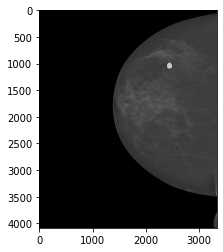

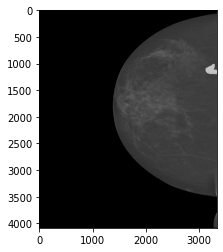

In [ ]:
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
masks, class_ids = train_set.load_mask(image_id)
print(masks.shape)
print(class_ids)
# plot image
print(masks.shape[2])

for i in range(masks.shape[2]):
  plt.pyplot.imshow(image)
  # plot mask
  plt.pyplot.imshow(masks[:, :, i], cmap='gray', alpha=0.5)
plt.pyplot.show()


[[1658 2258 2264 2712]]
[2]


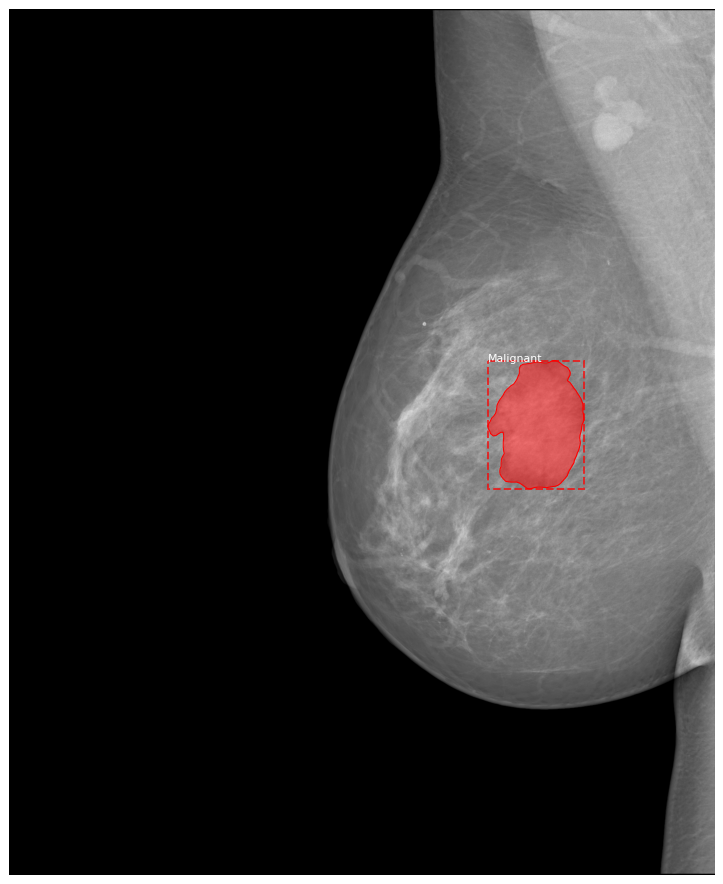

In [ ]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# define image id
image_id = 74
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
print(bbox)
print(class_ids)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
'''
%tensorflow_version 1.15.3
!pip install keras==2.2.4
'''
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

2.4.3
2.4.1


#**How to train a Mask RCNN Model?**
##**Defining the Config Object:**
Now that we're all set with loading our dataset as a mask-rcnn object dataset, we must move on towards using that data to train the model.

Although, much like any other deep learning model, we can also train a Mask RCNN model from scratch, in order to save time, we can use the mask-rcnn model prefit on either the MS COCO or Balloon dataset as a starting point and train only the last few 'head' layers of the model onto our own dataset since generally the model learns to detect basic features like edges in the starting layers and only learns to identify more complex features in the last few layers.

In order to use a prefit model, we must download the weights of that prefit model, in our case we will use the MS coco weights which we will need to download from [here](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5) and save it in our current working directory.

Next we will have to define a configuration object for the model.

This is a new class that extends the mrcnn.config.Config class and defines the attributes and hyper parameters to be used during both the training of the model as well as the inference on the testing set.

In this config object we must define the name of the config which will be used to save the log information regarding that particular run as well as the output weight files generated after each epoch during that training run. We must also define the number of total classes that we're trying to identify, which will 3 instead of 2 in our case since 0 is defined as the background class by default.

We can also use this config object to define additional configurations such as the the learning rate,learning momentum, pool size, image dimensions using the MIN_DIM and MAX_DIM fields as well as define the training and validation steps per epoch. Additionally we can find more parameters to try out in the config.py file under the mrcnn directory such as some normalization and padding settings as well as some GPU settings for better execution time performance.

We will be using the following training config object as shown below.




In [ ]:
from mrcnn.config import Config
class MammogramConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "SMALL"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 + 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 81

    # set validation steps 
    VALIDATION_STEPS = 26
    
config = MammogramConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

##**Defining the model:**
Now we will need to define our model in the training mode.

We can achive this by creating an instance of the mrcnn.model.MaskRCNN class and setting the mode to be training along with the training config object that we defined above.

We also need need to specify a directory where the config files will be saved along with the model weights at each checkpoint.

In our case we have specified the current working directory.



In [ ]:
from mrcnn.model import MaskRCNN
model = MaskRCNN(mode='training', model_dir='./', config=config)

##**Loading Model Weights:**

Now that our model is ready, we need to load the weight MS COCO weights we downloaded earlier, this can be done by using the load_weights function by specifying the weights path. However, since our model config is inconsistent with that of MS COCO as the output layers will be different since we are only predicting a total of 3 classes, we must exclude the last few layers while loading the MS COCO weights using the exclude keyword parameter.

We can do so by using the following line of code.

Note: Incase we want to resume training from a previously trained epoch on the same config, we do not need to exlclude the last few layers.

In [ ]:
#For First time load
model.load_weights('/content/drive/MyDrive/BCD/Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


#For continuation of training
#model.load_weights('/content/drive/MyDrive/BCD/Mask_RCNN/mrcnn/small20210324T1630/mask_rcnn_small_0005.h5', by_name=True)


Re-starting from epoch 5


##**Custom Callbacks:**
Mask RCNN model allows for a user to call custom callbacks at the end of each epoch in order to provide more control over the training process.

In our case, since the we will be training our model on significantly large sized images, it might take alot of time and hence it would be nice to know our progress status and therefore we will use the TQDM progress bar which is a widget which lets us know how many steps we've trained upon in each epoch.

We can find the TQDM progress bar in the tensorflow_addons library which we will have to install and instatiate a tqdm_callback object using the following code.

In [ ]:
!pip install tensorflow_addons

import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

##**Image Augmentation:**
Since we have an extremely small dataset to work with, we can adopt an extremely popular technique called image augmentation through which we can increase the number of images that our model can look at while training.

In image augmentation, we basically expand our dataset by applying some image processing technique on the original images. These techniques may include but aren't limited to taking random crops, rotations, guassian bluring, flipping etc as well as combinations of these.


We've defined an augmentation object with the following config which seemed to give the best results to us as shown in the code below.



In [ ]:
import imgaug.augmenters as iaa

augmentation = iaa.Sometimes(.667, iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.25.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.25))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2)),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-180, 180),
        #shear=(-8, 8)
    )
], random_order=True)) # apply augmenters in random order

#**Training the model:**
We can now finally begin training the model.The model can be fit on the training dataset by calling the train() function and passing in both the training testing datasets. We can also specifiy the learning rate incase we don't want to use the default learning rate which is 0.001, additionally we can also pass on an learning rate scheduler to incorporate a more dynamic learning rate throughout training. 

More over we have to specify which layers to train/fit the data upon, generally we will be only using the 'heads' layer which refer to the layers towards the end, additionally we can fine tune our model by training further epochs on either 'all' layers or any specific layers or segments of layers.

We will now train the 'heads' layers of the model, with the learning rate defined in the config along with the tqdm progressbar callback as well as the augmentation object that we defined earlier, using the following code.

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads', augmentation=augmentation custom_callbacks=[tqdm_callback])

##**Testing the model:**
Congratulations, now that we've finally trained a model, it is now time to evaluate the performance of our trained model.

The performance of a model for an object recognition task is often evaluated using the mean absolute precision, or mAP.

We are predicting bounding boxes so we can determine whether a bounding box prediction is good or not based on how well the predicted and actual bounding boxes overlap. This can be calculated by dividing the area of the overlap by the total area of both bounding boxes, or the intersection divided by the union, referred to as “intersection over union,” or IoU. A perfect bounding box prediction will have an IoU of 1.

It is standard to assume a positive prediction of a bounding box if the IoU is greater than 0.5, e.g. they overlap by 50% or more.

Precision refers to the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all bounding boxes predicted. Recall is the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all objects in the photo.

As we make more predictions, the recall percentage will increase, but precision will drop or become erratic as we start making false positive predictions. The recall (x) can be plotted against the precision (y) for each number of predictions to create a curve or line. We can maximize the value of each point on this line and calculate the average value of the precision or AP for each value of recall.

Note: there are variations on how AP is calculated, e.g. the way it is calculated for the widely used PASCAL VOC dataset and the MS COCO dataset differ.

The average or mean of the average precision (AP) across all of the images in a dataset is called the mean average precision, or mAP.

The mask-rcnn library provides a mrcnn.utils.compute_ap to calculate the AP and other metrics for a given images. These AP scores can be collected across a dataset and the mean calculated to give an idea at how good the model is at detecting objects in a dataset.


##**Defining the predictionc config:**

In order to use our model for inference, we must first define a new Config object to use for making predictions, even though we can extend our previously defined training config, we will redefine a new one seperately. The config must change some of the defaults around using the GPU for inference that are different from how they are set for training a model (regardless of whether you are running on the GPU or CPU).

Also note that some of parameters in the predictions config must match the ones used in the training config such as the image dimensions and paddding configs since the model layers are defined to take images with only those particular dimensions as inputs.

In [ ]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "predConfig"


    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 + 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 600

    # set number of epoch
    STEPS_PER_EPOCH = 150

    # set validation steps 
    #VALIDATION_STEPS = 26
    USE_MINI_MASK = False

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 10

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.60

    # Non-maximum suppression threshold for detection
    #DETECTION_NMS_THRESHOLD = 0.3


##**Loading our model for inference:**

Now that we have our prediction config defined, we can use it to load a MaskRCNN model in the 'inference' mode and then we can load any of our saved weights from training using the load_weights.

In [ ]:
import cv2
from mrcnn.model import mold_image
!pwd
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=config)
model.load_weights('/content/drive/MyDrive/BCD/Mask_RCNN/mrcnn/small20210324T1630/mask_rcnn_small_0005.h5', by_name=True)

/content
Re-starting from epoch 5


##**Evaluating the model:**
Now that we have the model ready to make inferences, we can evaluate its performance. This will require us to enumerate images in a dataset, making predictions and then finally calculating the mean AP accross all images in the dataset.

In order to calculate the mean AP, we will first need to load the image and its corresponding ground truth masks which can be loaded from the dataset using the load_imagegt() convenience function.

Next we will need to bring our the loaded pixel values of our testing dataset images to the same scale that was defined in our training config to match the input dimensions. This can be achieved using the mold_image() convenience function.

After the images have been brought to the same scale, the dimensions of the image then need to be expanded to one sample in a dataset and used as input to make a prediction with the model.

We can then use the sample to make predictions using the model.detect() function.


And finally, we can use the detection output to compute the AP value for that particular image, which can be achieved by the computer_ap() function and lastly, use the collective AP of the entire dataset to compute the mAP to benchmark our model performance.

Let's see how we can do all that in the evaluate_model() function defined below.


In [ ]:
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP



Considering the task at hand is fairly complicated, while the dataset is extremely small and given our time restrictions, we believe to have achieved decent results training the model on grayscale images while noticing a significant increase in the model performance when incorporating the psuedo color imaging technique in our preprocessing pipeline.


The code for the psuedo color imaging is provided in this notebook, however for the sake of simplicity the demonstration is done on the pipeline which excludes it.

##**Making Predictions on single mammograms**
In order to run our model on any arbitrary mammogram image outside the dataset, we can simply define the model in inference mode, load the weights as before and then use cv2 to read an image, scale it and transform it into a sample as we did before in the evaluate_model() function and then make a prediction on that particular sample as shown in the code below. 

In [ ]:
#Defining the prediction config and loading the model
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=config)
model.load_weights('/content/drive/MyDrive/BCD/Mask_RCNN/mrcnn/small20210324T1630/mask_rcnn_small_0005.h5', by_name=True)


#Loading an image through cv2
image = cv2.imread('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs/27829134.png')
#image = cv2.imread('/content/drive/MyDrive/BCD/Inbreast_Dataset/mass_PNGs/22614568.png')

# convert pixel values (e.g. center)
scaled_image = mold_image(image, config)
# convert image into one sample
sample = np.expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)
print(yhat)

##**Visualizing the predictions:**
Finally, in order to display the predictions made by our model, we can easily display them using the display_instances() convenience function provided in the mrcnn library as shown by the code below.

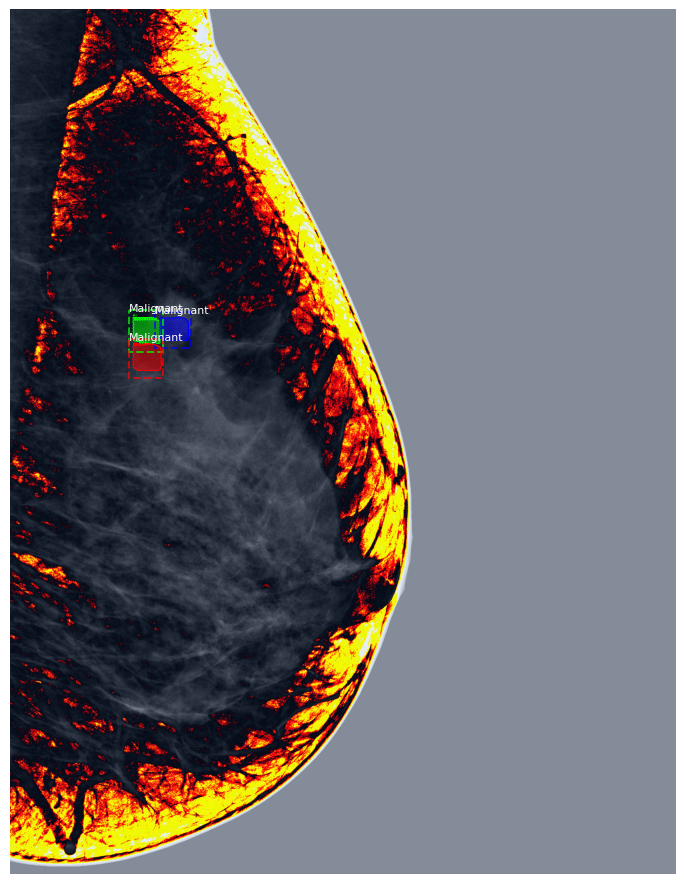

In [ ]:
from mrcnn.visualize import display_instances
display_instances(scaled_image, yhat[0]['rois'], yhat[0]['masks'], yhat[0]['class_ids'], train_set.class_names)

Thats about it, you now know how to train and use a Mask RCNN model to simultaneously performe detection, localization and segmentation tasks!

##**References**

##**Thank You for reading!**

This notebook was written and submitted as a final year project at the Institute of Business Administration Karachi in 2021 and was authored by

1)Muhammad Ahsan Rahim\
2)Ammar Ahmad Alvi

Special thanks to our FYP supervisor **Dr. Tahir Syed** for guiding us throughout the report.


